# Introduction to Computer Vision (CIVI1000) Machine Project 

XC23
<br> Albo, Leigh Gwyneth M.
<br> Barte, Lian Carlos M.
<br> Orcullo, Rlsrain Mackenlhy G.
<br> Villamor, Allysa Luise Nelfa D.

The first phase of the project involves 4 sections – (1) list of requirements, (2) description of the
dataset, (3) exploratory data analysis, and (4) traditional ML model training.

# *Machine Project Phase 1*

## Section 1. List of requirements
Below are the list of Python libraries and modules used in the entirety of the project.

In [ ]:
# Core Data Handling and OS
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm import tqdm
import random
import seaborn as sns
import importlib

# Machine Learning and Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from sklearn.utils import resample
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import lru_cache

# additional for running in colab
import zipfile
import sys
import importlib

These libraries form the foundation for both **data preprocessing** and **model development** in this project.

- **pandas** and **numpy** - for handling and processing tabular and numerical data.  
- **os**, **sys**, and **zipfile** - for working with file paths, directories, and compressed datasets.  
- **PIL (Python Imaging Library)** and **cv2 (OpenCV)** - for loading, converting, and resizing images.  
- **matplotlib** and **seaborn** - for visualizing images, class distributions, and performance results.  
- **tqdm** - for adding progress bars to loops, helping monitor loading or training processes.  
- **scikit-learn (sklearn)** - for data splitting, feature scaling, traditional machine learning models (like k-NN and Logistic Regression), PCA for dimensionality reduction, and performance evaluation metrics.


In [ ]:
import utils
importlib.reload(utils)
from utils import compute_accuracy


## Section 2. Description of the dataset

The clinical skin disease dataset used, named SD-198, is the largest available skin disease database as of 2016, whether clinical or dermoscopic images are mentioned. The dataset is a solution against datasets previously used for skin disease studies that are not publicly available. However, the dataset used for this project is SD-128 which also comprises SD-198. It is assumed that the same processes and discussions were applied in the SD-128 dataset.


The SD-198 dataset contains 6,584 images in total varying from 198 different skin diseases from different types of eczema, acne, and various cancerous conditions. The SD-128 dataset, which was given for this project, was also chosen containing more than 20 image samples as a subset. It is difficult to distinguish between the skin disease images as some of them may look exactly the same with their color and shape.

As mentioned in the paper, the images are downloaded from DermQuest, which is an online medical resource for dermatologists and healthcare professionals. There are 720 species of skin lesions in total, which include all kinds of conditions that affect the integumentary system; however, a statistical analysis was done and species that rarely appear in real life or have less than 10 samples were removed. To balance the categories of the dataset, some images were removed from subsets that have sufficient data, to keep 60 images at each category at most despite the initial collection of 10,000 clinical skin disease images. Further filtration of the images was then done by removing duplicates and low-quality images. The SD-198 dataset was then finalized with 6,584 images and 198 different skin disease categories.

 However, the information regarding images in SD-128, which is used in this project, will be discussed later in the code. The SD-128 dataset contains the images folder which also contains multiple subfolders where each subfolder represents a class or skin disease. There should be 128 subfolders corresponding to 128 different classes and each subfolder contains at most 60 images. The dataset also contains text files that list the relative file path of the images in the training and testing data.

The training and testing datasets are loaded into its own dataframe. The combined dataframe is made by combining the training and testing datasets and is used to visualize the overall dataset of SD-128 for this project.

In [ ]:
train_df = pd.read_csv('SD-128/train.txt', sep=' ', header=None, names=['Path', 'Label'])
test_df = pd.read_csv('SD-128/test.txt', sep=' ', header=None, names=['Path', 'Label'])
combined_df = pd.concat([train_df, test_df], ignore_index=True)

train_df_cnn = train_df.copy()
test_df_cnn = test_df.copy()

To ensure that the data is loaded correctly in the dataframe, information for each dataframe or how it looks in the dataframe is printed.

In [ ]:
# 1. Initial Data Inspection (Crucial EDA Step)
print("--- Training Data Info (.info()) ---")
train_df.info()

print("\n--- Testing Data Info (.info()) ---")
test_df.info()

print("\n--- Overall Data Info (.info()) ---")
combined_df.info()

In [ ]:
train_df.head(5)

In [ ]:
test_df.head(5)

In [ ]:
combined_df.head(5)

This part of the code prepares a mapping between numeric class labels and their corresponding class names, ensuring that all 128 expected classes are represented even if some are missing in the dataset.

In [ ]:
label_to_path = combined_df.drop_duplicates(subset='Label').set_index('Label')['Path'].to_dict()
label_to_name = {lbl: label_to_path[lbl].split('/')[0] for lbl in label_to_path}

expected_min_classes = 128
max_label_seen = int(combined_df['Label'].max())
total_classes = max(expected_min_classes, max_label_seen + 1)
labels = list(range(total_classes))

This loop fills in missing class names to ensure every label from 0 to the 127 has a corresponding entry in label_to_name.

In [ ]:
for lbl in labels:
    if lbl not in label_to_name:
        label_to_name[lbl] = f"Class_{lbl}"

This code computes and displays basic dataset statistics for the training, testing, and overall data. The following information shows the characteristics of the SD-128 dataset which the paper wasn't able to specifically discuss.

In [ ]:
num_train = len(train_df)
num_test = len(test_df)
num_combined = len(combined_df)
num_classes_train = train_df['Label'].nunique()
num_classes_test = test_df['Label'].nunique()
num_classes = num_classes_train
num_classes_combined = combined_df['Label'].nunique()

# diff between nunique and .value_count() - nunique return just n classes, while .value counts return n PER classes


print(f"Number of Training Samples: {num_train}")
print(f"Number of Testing Samples: {num_test}")
print(f"Number of Overall Samples: {num_combined}")
print(f"Number of Classes: {num_classes_train}")
print(f"Number of Classes: {num_classes_test}")

This code performs class mapping which basically maps the numeric labels into names for exploratory data analysis and representations.

In [ ]:
class_map = combined_df.drop_duplicates(subset='Label').set_index('Label')['Path'].apply(lambda x: x.split('/')[0]).to_dict()
class_names = [class_map[i] for i in range(num_classes)]
for i in range(num_classes_test):
  print(f"Label {i}: {class_map[i]}")

## Section 3. Exploratory data analysis

To gain a better understanding of the dataset, identify potentify challenges, and discuss how some factors might affect training outcomes, exploratory data analysis, also known as eda, was done.

The first form of data visualization used is a bar chart for each of the overall, training, and testing datasets. It is important to check for the visualization for each of the datasets to be able to infer whether the sampling between the training and testing is valid or suitable based on how the overall data is distributed.

This code presents a bar chart of the overall distribution of images across classes (skin diseases) in the SD-128 dataset. It is essential to check the distribution of samples between classes to detect class imbalance which is said to be common in medical datasets from research.

In [ ]:
class_counts = combined_df['Label'].value_counts().sort_index()

labels = sorted(class_counts.index)
class_names = [class_map[lbl] for lbl in labels]

plt.figure(figsize=(20, 5))
plt.bar(class_names, class_counts)
plt.title('Distribution of Images Across Classes in SD-128')
plt.xlabel('Disease Name')
plt.ylabel('Number of Samples')
plt.xticks(rotation=90, fontsize=8)
plt.grid(axis='y', alpha=0.5)
plt.show()

Seeing the bar graph for the distribution we can assess that the images are spread randomly among all the classes in SD-128 with a slight disparity in some classes. While most of the classes have a relatively balanced distribution to the classes, there are several diseases that have fewer samples. The noticeable imbalance may affect the model performance since it can lead to biased predictions, but could be indicative of the rarity of the diseases. Other than that, we can still see the diversity of the dataset.

In [ ]:
class_counts_train = train_df['Label'].value_counts().sort_index()

labels = sorted(class_counts_train.index)
class_names = [class_map[lbl] for lbl in labels]

plt.figure(figsize=(20, 5))
plt.bar(class_names, class_counts_train)
plt.title('Distribution of Images Across Classes in Training Set')
plt.xlabel('Disease Name')
plt.ylabel('Number of Samples')
plt.xticks(rotation=90, fontsize=8)
plt.grid(axis='y', alpha=0.5)
plt.show()

For the training set, it contains 128 skin disease classes with up to 30 samples per class, showing both variety and controlled distribution.
This combination reflects high diversity, but since image counts range only from 10 to 30, it makes the classification task more challenging for the model.
The limited examples per class may also highlight the rarity of certain diseases within the dataset.

In [ ]:
class_counts_test = test_df['Label'].value_counts().sort_index()

labels = sorted(class_counts_test.index)
class_names = [class_map[lbl] for lbl in labels]

plt.figure(figsize=(20, 5))
plt.bar(class_names, class_counts_test)
plt.title('Distribution of Images Across Classes in Testing Set')
plt.xlabel('Disease Name')
plt.ylabel('Number of Samples')
plt.xticks(rotation=90, fontsize=8)
plt.grid(axis='y', alpha=0.5)
plt.show()

For the testing set, it maintains the same distribution of images as the training data, where most classes contain about 10 to 30 samples and a spread out partitioning of the classes is present.

This code simply provides or prints summary statistics of the samples in the overall, training, and testing datasets which can also be seen from the visualization above.

In [ ]:
min_samples = class_counts.min()
max_samples = class_counts.max()
mean_samples = class_counts.mean()

print("Overall")
print("Min Max Mean")
print(min_samples,
      max_samples,
      mean_samples)

min_samples_train = class_counts_train.min()
max_samples_train = class_counts_train.max()
mean_samples_train = class_counts_train.mean()

print("\nTrain")
print("Min Max Mean")
print(min_samples_train,
      max_samples_train,
      mean_samples_train)

min_samples_test = class_counts_test.min()
max_samples_test = class_counts_test.max()
mean_samples_test = class_counts_test.mean()

print("\nTest")
print("Min Max Mean")
print(min_samples_test,
      max_samples_test,
      mean_samples_test)

Across all 128 skin disease classes, the SD-108 dataset shows a moderate spread in the number of samples per class.

- Overall dataset: ranges from 20 to 60 images per class, averaging about 44 samples.

- Training and testing sets: both range from 10 to 30 samples per class, averaging around 22 images each.

With this, it indicates that the dataset is fairly balanced among the training and testing sets. The limited sample size per class may impose a challenge to the models ability to learn detailed features, but would allow us to evalueat the models .

Sample images in classes are then checked before training. It is important to perform this step to have some kind of qualitative analysis on the samples. By checking sample images you'll be able to check whether the images are correctly labeled, image quality is not corrupted, and each class has sufficiently different examples under the same class.

Based on the sample images, you can see that more than one image in the same class has the same person or test subject. In terms of how the shots were taken, the images show great performance in highlighting the skin diseases.

In [ ]:
base_dir = './SD-128/images'

def resolve_paths(df, base_dir):
    resolved_paths, exists_flags = [], []
    for rel_path in df['Path']:
        full_path = os.path.join(base_dir, rel_path)
        resolved_paths.append(full_path)
        exists_flags.append(os.path.exists(full_path))
    df = df.copy()
    df['resolved_path'] = resolved_paths
    df['file_exists'] = exists_flags
    return df

train_df_eda = resolve_paths(train_df, base_dir)
test_df_eda  = resolve_paths(test_df, base_dir)
combined_df_eda = pd.concat([train_df_eda, test_df_eda], ignore_index=True)

def show_samples_resolved(df, n_samples=3, max_classes=8, title_prefix=""):
    labels_sorted = sorted(df['Label'].unique())[:max_classes]
    rows, cols = len(labels_sorted), n_samples
    plt.figure(figsize=(cols*3, rows*3))
    idx = 1
    for lab in labels_sorted:
        candidates = df[(df['Label'] == lab) & (df['file_exists'])]
        if candidates.empty:
            continue
        samples = candidates.sample(min(n_samples, len(candidates)), random_state=42)
        for _, r in samples.iterrows():
            try:
                img = Image.open(r['resolved_path']).convert('RGB')
                plt.subplot(rows, cols, idx)
                plt.imshow(img)
                plt.axis('off')
                if (idx - 1) % cols == 0:
                    plt.ylabel(f"Label {lab}", fontsize=9)
            except Exception as e:
                plt.subplot(rows, cols, idx)
                plt.axis('off')
            idx += 1
    plt.suptitle(f"Sample images per class ({title_prefix})", fontsize=14)
    plt.tight_layout()
    plt.show()

show_samples_resolved(train_df_eda, n_samples=3, max_classes=8, title_prefix="Training Set")

In [ ]:
show_samples_resolved(test_df_eda,  n_samples=3, max_classes=8, title_prefix="Testing Set")

In [ ]:
show_samples_resolved(combined_df_eda, n_samples=3, max_classes=8, title_prefix="Combined Set")

As previously discussed in data preprocessing, it is important to check the sizes of the samples as there is a fixed number of neurons to input when feeding images into the neural network. Scatterplots for the image sizes of the overall, training, and testing datasets are then formed. It indicates whether there should be resizing decisions or strategies. This step also helps in detecting outliers that will distort training.

Here, a width vs. height scatter plot is used to reveal the dimensional variance of the images, which is useful to decide on a necessary standardization step like resizing or cropping.

In [ ]:
@lru_cache(maxsize=100000)
def _cached_get_size(path):
    try:
        with Image.open(path) as img:
            return img.size
    except Exception:
        return None

def collect_image_sizes(df, max_samples=100, workers=16):
    valid_paths = df[df['file_exists']]['resolved_path'].tolist()
    if not valid_paths:
        return [], []


    sample_paths = random.sample(valid_paths, min(max_samples, len(valid_paths)))

    sizes = []
    n_workers = min(len(sample_paths), workers)
    with ThreadPoolExecutor(max_workers=n_workers) as ex:
        futures = {ex.submit(_cached_get_size, p): p for p in sample_paths}
        for fut in as_completed(futures):
            res = fut.result()
            if res:
                sizes.append(res)

    if not sizes:
        return [], []

    widths, heights = zip(*sizes)
    return widths, heights

In [ ]:
widths_train, heights_train = collect_image_sizes(train_df_eda)
widths_test, heights_test = collect_image_sizes(test_df_eda)
widths_combined, heights_combined = collect_image_sizes(combined_df_eda)

In [ ]:
if widths_train:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=widths_train, y=heights_train)
    plt.title("Training Set - Image Width vs Height (sample)")
    plt.xlabel("Width (px)")
    plt.ylabel("Height (px)")
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("No valid images found in Training Set for size scatter.")

For the training set, the scatter plot visualizes the dimensions (width vs. height) of sample images in SD-108. The plot clearly shows that the images are not a uniform size. Instead, they are clustered into several different dimensions. This variation of dimensions entails the need for a preprocessing step where all images are resized to a standard 64x64 dimension, ensuring that there will be a consistent input for the machine learning models.


In [ ]:
if widths_test:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=widths_test, y=heights_test, color="orange")
    plt.title("Testing Set - Image Width vs Height (sample)")
    plt.xlabel("Width (px)")
    plt.ylabel("Height (px)")
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("No valid images found in Testing Set for size scatter.")

In the testing set, which was similar to the training set, the plot shows that images in the testing set also have varying original dimensions. This confirms the importance of the preprocessing step of making all images (from both sets) resized to a uniform 64x64. This standardization is critical to ensure the model can correctly process the test images using the same input shape it was trained on.

In [ ]:
if widths_combined:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=widths_combined, y=heights_combined, color="green")
    plt.title("Combined (Overall) - Image Width vs Height (sample)")
    plt.xlabel("Width (px)")
    plt.ylabel("Height (px)")
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("No valid images found in Combined Set for size scatter.")

With this scatter plot, it confirms that there is a dimension variance across the entire (combined) dataset. Like in the individual training and testing plots, this graph shows that the original images come in multiple, non-uniform sizes. This emphasizes the critical need for the preprocessing step, where all images are resized to ensure consistent input for the model.


Lastly, an RGB histogram is used to reveal brightness/contrast of the images and whether color channels contain discriminative information which is useful to decide normalization or grayscale conversion.

In [ ]:
def show_rgb_histogram(df, title="Dataset"):
    """Shows RGB histogram for one random valid image from the given dataset."""
    valid_paths = df[df['file_exists']]['resolved_path'].tolist()
    if not valid_paths:
        print(f"No valid images found for {title}.")
        return

    sample_img_path = random.choice(valid_paths)
    try:
        img = Image.open(sample_img_path).convert('RGB')
        r, g, b = img.split()

        plt.figure(figsize=(10,4))
        plt.hist(np.array(r).flatten(), bins=50, alpha=0.5, label='R', color='red')
        plt.hist(np.array(g).flatten(), bins=50, alpha=0.5, label='G', color='green')
        plt.hist(np.array(b).flatten(), bins=50, alpha=0.5, label='B', color='blue')

        plt.title(f'Color Channel Intensity — {title}\nSample: {os.path.basename(sample_img_path)}')
        plt.xlabel('Pixel Intensity (0–255)')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    except Exception as e:
        print(f"Could not open sample for {title} histogram:", e)

print("Training Set RGB Histogram:")
show_rgb_histogram(train_df_eda, title="Training Set")

The histogram shows the pixel intensity distribution across the red, green, and blue channels in a sample training images.
Most of the pixels cluster around the lower and upper intensity values, indicating a strong contrast and bright regions.
The uneven distribution between the three color channels tells of variations in lighting and skin tones, which can affect model performance if not normalized properly.

In [ ]:
print("Testing Set RGB Histogram:")
show_rgb_histogram(test_df_eda, title="Testing Set")

The RGB histogram for the testing set shows a much broader spread of pixel intensities compared to the training set.
The blue channel has more low-intensity values, while red remains in the higher range.
This variation may suggest differences in lighting or image composition between sets, emphasizing the need for normalization to ensure consistent model performance.

In [ ]:
print("Combined Dataset RGB Histogram:")
show_rgb_histogram(combined_df_eda, title="Combined Set")

For the combined dataset, the graph shows a significant and a consistent spread across all the three channels, where the red channel spreads around the 150 intensity mark and a wider distribution in the blue channel. With this, it indicates that, as a whole, the dataset contains images with varying lighting and color casts.

The noticeable spike in the blue channel is likely representing a common artifact or background color in some images. This variability across the combined set reinforces the need for data normalization before training, ensuring the model will not be bias.

This code prepares image data for traditional machine learning models by loading, resizing, and flattening images into numerical vectors.

In [ ]:
IMAGE_SIZE = (64, 64)

base_dir = 'SD-128/images'

def load_and_preprocess_images(df):
    x = []
    y = []

    for path, label in tqdm(df.values, desc=f"Loading {len(df)} Images"):
        full_path = os.path.join(base_dir, path)
        try:
            # 1. Load image and convert to 3-channel RGB using PIL
            img = Image.open(full_path).convert('RGB')

            # 2. Resize to consistent dimensions (64x64) using PIL
            img_resized = img.resize(IMAGE_SIZE)

            # 3. Convert PIL image to a NumPy array (shape: 64, 64, 3)
            img_array = np.array(img_resized)

            # 4. Flatten the array into a 1D vector (64x64x3 = 12288)
            x.append(img_array.flatten())
            y.append(label)

        except FileNotFoundError:
            print(f"Warning: Image not found at {full_path}. Skipping.")
        except Exception as e:
            print(f"Warning: Error processing {full_path}. Skipping. Error: {e}")

    return np.array(x), np.array(y)

In [ ]:
train_data_raw, train_label = load_and_preprocess_images(train_df)
test_data_raw, test_label = load_and_preprocess_images(test_df)

In [ ]:
print(train_data_raw)
print(test_data_raw)

In [ ]:
print(f"\nFinal Training Data Shape (Samples x Features): {train_data_raw.shape}")
print(f"Final Test Data Shape (Samples x Features): {test_data_raw.shape}")

A small, random subset of the RAW training data is selected. Each 1D feature vector is successfully reshaped back into a 64x64 RGB image tensor. The images are displayed with their corresponding disease names, confirming the data pipeline works and visually illustrating the high intra-class variability and fine-grained nature of the dataset.

In [ ]:
HEIGHT = 64
WIDTH = 64
CHANNELS = 3

num_samples_to_show = 16
np.random.seed(42)
random_indices = np.random.choice(len(train_data_raw), num_samples_to_show, replace=False)

plt.figure(figsize=(10, 10))

try:
    data_for_display = train_data_raw
except NameError:
    data_for_display = train_data
    print("Warning: Displaying scaled data. Image colors might be distorted.")


for i, idx in enumerate(random_indices):
    flat_vector = data_for_display[idx]

    img = flat_vector.reshape(HEIGHT, WIDTH, CHANNELS)

    label = train_label[idx]
    title = f"{class_map[label]} ({label})"

    plt.subplot(4, 4, i + 1)
    plt.imshow(img.astype(np.uint8))
    plt.title(title, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

This cell divides the raw test dataset into two subsets: a validation set and a final test set, ensuring balanced class distribution and consistent evaluation.

In [ ]:
# Assuming you previously loaded and scaled your data:
# X_train_scaled is the full feature set, y_train is the full label set.

X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    train_data_raw, train_label,
    test_size=0.2,
    random_state=1,
    stratify=train_label
)


X_test_raw = test_data_raw
y_test = test_label

In [ ]:
train_data = X_train_raw
train_label = y_train

validation_data = X_val_raw
validation_label = y_val

test_data = X_test_raw
test_label = y_test


print(f"Training Data Size: {len(train_data)}")
print(f"Validation Data Size: {len(validation_data)}")
print(f"Test Data Size: {len(test_data)}")

This cell balances the training dataset by oversampling underrepresented classes to match the size of the largest class, ensuring fair and unbiased model training.

In [ ]:
train_combined = np.hstack((train_data, train_label.reshape(-1, 1)))

train_df = pd.DataFrame(train_combined)
train_df.columns = [f"f{i}" for i in range(train_data.shape[1])] + ["label"]

max_samples = train_df['label'].value_counts().max()

balanced_dfs = []
for label, group in train_df.groupby('label'):
    balanced = resample(group, replace=True, n_samples=max_samples, random_state=42)
    balanced_dfs.append(balanced)

balanced_train_df = pd.concat(balanced_dfs, ignore_index=True)

y_train_bal = balanced_train_df['label'].values.astype(int)
X_train_bal = balanced_train_df.drop(columns=['label']).values.astype(np.float32)

print(f"Before balancing: {len(train_label)} samples")
print(f"After balancing: {len(y_train_bal)} samples")

In [ ]:
scaler = StandardScaler()
train_data = scaler.fit_transform(X_train_bal)
validation_data = scaler.transform(validation_data)
test_data = scaler.transform(test_data)

train_label = y_train_bal
validation_label = y_val
test_label = y_test

## Section 4. Traditional ML model training

This section explores baseline machine learning models for skin disease classification.  We first train a k-Nearest Neighbors (k-NN) model on raw image data, then apply Principal Component Analysis (PCA) to reduce dimensionality and improve efficiency.  Finally, we implement a simple Neural Network (MLP) from scratch using NumPy to compare performance against traditional methods.

Both k-NN and NN models were used to show and highlight on the difference of non-parametric and parametric training, with k-NN being non-parametric and NN being parametric. However having both models still work in handy. k-NN provides baseline accuracy with minimal training time. NN will likely achieve higher accuracy and better feature discrimination.


### 4.1. kNN Model Training

We begin with the k-Nearest Neighbors (k-NN) algorithm as a simple baseline.  The model classifies an image by comparing it to the *k* most similar training samples and choosing the majority label.

A k-NN model training was first implemented to minimize model complexity first. Since the dataset or images to classify are of skin diseases that have textures, colors, and shapes that vary significantly, k-NN is the key for non-linear data.

In [ ]:
sys.path.append(r"C:\Users\leigh\Downloads\CIVI100\Machine Project Phase 1")
import kNearestNeighbor
importlib.reload(kNearestNeighbor)
from kNearestNeighbor import KNearestNeighbor

The above code imports and reloads the custom module kNearestNeighbor, which contains the implementation of the KNearestNeighbor class.

In [ ]:
model = KNearestNeighbor()

After the import, an instance of the KNearestNeighbor class is created and stored in the variable model. This instance represents our k-Nearest Neighbors classifier. Unlike deep learning models, KNN does not perform any parameter learning during training. Instead, it simply stores all the training samples and their corresponding labels so they can be compared later when predicting unseen data.

In [ ]:
model.train(train_data, train_label)

The train() function saves the training data and labels inside the model. Since kNN is a non-parametric method, there is no optimization or weight adjustment happening here, it is merely memorizing the data.

To make sure that the model is performing well, a sanity check is done. Since this is KNN, the nearest neighbors of each instance should be itself.

In [ ]:
predictions = model.evaluate(train_data, train_label, k=1)

After evaluating, we will now check the accuracy. As mentioned, the nearest neightbor is itself, so we are expecting a 1.0 accuracy from the kNN model.

In [ ]:
from utils import compute_accuracy

train_accuracy = compute_accuracy(train_label, predictions)

print(np.around(train_accuracy, 1))

As expected, the accuracy is 1.0, which mean the model is working fine. Therefore, we can now proceed and utilize the model for the validation set.

This cell evaluates how the number of neighbors (k) in a k-Nearest Neighbors (k-NN) classifier affects its classification accuracy on the validation dataset.

In [ ]:
k_values = [1, 3, 5, 7, 9, 20, 100, 500]
accuracy_per_k = []


for k in k_values:
    val_preds = model.evaluate(validation_data, validation_label, k=k)
    acc = compute_accuracy(validation_label, val_preds)
    accuracy_per_k.append(acc)

for i, k in enumerate(k_values):
    print('Validation Accuracy (k=' + str(k) + '): ' + str(np.around(accuracy_per_k[i], 3)))

These results show that smaller k values perform slightly better because they focus on closer neighbors and preserve more local structure. As k increases, the classifier becomes too generalized and accuracy gradually decreases Although the overall accuracies appear low, this is expected given that the dataset contains many different classes. With dozens of possible labels, achieving random accuracy would be much lower than 16 %, so this still indicates that the model is learning real patterns rather than predicting by chance.The steady downward trend as k increases also confirms that the model behaves logically, that its predictions are consistent, not random.

Because the initial accuracies were low, we applied Principal Component Analysis (PCA) to reduce the feature dimensionality from 12,288 to 100.
This step was part of parameter tuning, aiming to simplify the feature space, remove redundancy, and help the model find more meaningful distance relationships between samples.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
train_data_pca = pca.fit_transform(train_data)
validation_data_pca = pca.transform(validation_data)

model.train(train_data_pca, train_label)

for k in k_values:
    val_preds = model.evaluate(validation_data_pca, validation_label, k=k)
    acc = compute_accuracy(validation_label, val_preds)
    print(f"Validation Accuracy (k={k}): {acc:.3f}")


The increase is smal but shows that PCA still helped, allowing the model to measure distances more effectively. Since PCA still led to a small improvement, we also applied the same PCA transformation to our test evaluation.

Using the same PCA representation, the model was tested on unseen samples:

In [ ]:
test_data_pca = pca.transform(test_data)

for k in k_values:
    test_preds = model.evaluate(test_data_pca, test_label, k=k)
    acc = compute_accuracy(test_label, test_preds)
    print(f"Test Accuracy (k={k}): {acc:.3f}")


The best test accuracy (~16 %) matches the validation performance, confirming consistent generalization. Again, while 16% may seem small, it’s not random — with many output classes, this score demonstrates that the model can recognize certain visual similarities better than chance. However, the performance plateau also highlights k-NN’s limitation: even with PCA, it still struggles to handle complex, high-dimensional image data.

Overall, k-NN performs reasonably as a non-parametric baseline, but its limitations motivate moving toward parametric models like neural networks for higher accuracy, especially convolutional.

###4.2 Neural Network Model Training

In this subsection, we begin building a multi-layer neural network (MLP) from scratch using NumPy.  

The model uses ReLU or Sigmoid activations and a Softmax output layer for multiclass classification.  Before training, all image data is normalized and reshaped to ensure stable learning and correct input dimensions.

Compared to k-NN, using Neural Networks now allow more complexity in training the data highlighting the difference with using a non-parametric and parametric approach. Using NN provides a more data-driven approach compared to simply comparing image similarity in feature space. Since classifying skin diseases means taking note of even the smallest differences, NN's approach helps in properly modelling if properly tuned.

In [ ]:
sys.path.append(r"C:\Users\leigh\Downloads\CIVI100\Machine Project Phase 1")
import multiLayerNeuralNetwork
importlib.reload(multiLayerNeuralNetwork)
from multiLayerNeuralNetwork import MultiLayerNN


The above code imports the custom Multi-Layer Neural Network implementation from the multiLayerNeuralNetwork.py file located in the project directory. Finally, the class MultiLayerNN is imported from the module.

This code normalizes image data to prepare it for model training and defines the architecture of a multilayer neural network by specifying layer dimensions.

In [ ]:
train_data = X_train_bal.astype(np.float32) / 255.0
validation_data = X_val_raw.astype(np.float32) / 255.0
test_data = X_test_raw.astype(np.float32) / 255.0

train_data = (train_data - 0.5) / 0.5
validation_data = (validation_data - 0.5) / 0.5
test_data = (test_data - 0.5) / 0.5

train_label = y_train_bal.astype(np.int64)
validation_label = validation_label.astype(np.int64)
test_label = test_label.astype(np.int64)

#---------------
print("train_data shape:", train_data.shape)
print("train label shape:", train_label.shape)
print("validation_data shape:", validation_data.shape)
print("validation label shape:", validation_label.shape)
print("test_data shape:", test_data.shape)
print("test label shape:", test_label.shape)
print("Unique train labels:", np.unique(train_label))
#---------------

This cell prepares and normalizes the data before training the neural network.
All image pixel values are divided by 255.0 to scale them from [0–255] → [0–1], then standardized to [-1, 1] using (data – 0.5)/0.5 for faster and more stable learning. The labels are converted to integers for classification. Finally, the shapes and unique class labels are printed to confirm that all datasets are correctly formatted and aligned before training.

In [ ]:
input_size  = train_data.shape[1]
num_classes = 128


This cell defines two important parameters for the neural network.
input_size gets the number of features per image from the training data, which determines the size of the input layer.
num_classes = 128 specifies the total number of output categories for classification, which sets the number of neurons in the output layer.

This code performs a sanity check to verify that the custom MultiLayer Neural Network (MultiLayerNN) implementation is functioning correctly by training and validating on the same dataset.

In [ ]:
from utils import compute_accuracy

print("Sanity Check (Train Set Accuracy)")

model = MultiLayerNN(
    layer_sizes=[input_size, 512, num_classes],
    activation="relu",
    l2=1e-4,
    seed=42
)

# Train using the same data for both training and validation
model.train(
    train_data, train_label,
    val_data=train_data, val_labels=train_label,
    epochs=15, lr=5e-3, batch_size=64, verbose=True
)

# Evaluate on the same training data
train_preds = model.evaluate(train_data)
train_acc = compute_accuracy(train_label, train_preds)

print("Sanity check accuracy on training subset:", train_acc)


This cell performs a sanity check to verify that the neural network implementation is working correctly. The model is trained and validated on the same dataset to ensure it can learn and fit the training data. As seen from the increasing validation accuracy (from 9.71% → 68.62%), the model successfully reduces loss and improves performance over epochs. This confirms that the forward pass, backpropagation, and parameter updates are functioning as expected before testing on unseen data.

Since the model showed positive results to the sanity check, we can proceed to evaluate the model to the validation set. This setup measures how well the model can generalize to new examples instead of memorizing the training data, unlike the previous sanity check where both sets were identical.

In [ ]:
from utils import compute_accuracy

print("Validation Set Accuracy")

# Train on training set, validate on real validation set
model.train(
    train_data, train_label,
    val_data=validation_data, val_labels=validation_label,
    epochs=15, lr=5e-3, batch_size=64, verbose=True
)

# Evaluate on validation set (separately)
val_preds = model.evaluate(validation_data)
val_acc = compute_accuracy(validation_label, val_preds)

print("Validation accuracy:", val_acc)

As expected, the validation accuracy is lower than before, but it is gradually improving as epoch increases. While this seems small, it still shows that the model is learning meaningful patterns and not performing randomly. Given that this dataset has many output classes (128 total), even small accuracy improvements are significant as random guessing would only achieve less than 1% accuracy. The result also reflects a realistic limitation of shallow neural networks: although the model can learn basic representations, its capacity is still not enough to fully capture the complex visual differences across 128 categories.

Since our original input features have 12,288 dimensions, the data may be too high-dimensional and noisy, making learning difficult. To address this, we apply Principal Component Analysis (PCA) to reduce the feature space to 1,028 components. This step is part of parameter tuning — testing whether a smaller, denoised input allows the neural network to learn better patterns and improve validation performance

In [ ]:
print("\nValidation Test Accuracy on PCA-reduced input")

n_components=1028
pca = PCA(n_components, random_state=42)
train_data_pca = pca.fit_transform(train_data)
validation_data_pca = pca.transform(validation_data)
test_data_pca = pca.transform(test_data)

print("Original input dimension:", train_data.shape[1])
print("Reduced input dimension:", train_data_pca.shape[1])

model_pca = MultiLayerNN(
    layer_sizes=[n_components, 512, num_classes],
    activation="relu",
    l2=1e-4,
    seed=42
)

model_pca.train(
    train_data_pca, train_label,
    val_data=validation_data_pca, val_labels=validation_label,
    epochs=15, lr=5e-3, batch_size=64, verbose=True
)

val_preds = model_pca.evaluate(validation_data_pca)
val_acc = compute_accuracy(validation_label, val_preds)

print("\nValidation accuracy (PCA):", val_acc)

The model trained on PCA-reduced features achieved a final validation accuracy of about 11.74%. Although this is slightly lower than the non-PCA result (~16.65%), the accuracy trend still shows that the model is learning consistently, not guessing randomly. This suggests that while PCA helped remove noise from the original 12k-dimensional space, some useful information was also lost in compression.

#### PCA-Reduced Neural Network (Increasing Architecture) — Optional Test

This section serves as an additional exploratory test to see how an increasing neural network architecture performs on PCA-reduced features.
Unlike the previous setup, which focused on tuning through a decreasing architecture to minimize noise, this test expands the hidden layer size (from 1,028 to 2,056) to observe whether allowing more neurons improves performance. The idea is to check if expanding the network’s capacity can help recover information lost during PCA compression. However, this configuration is not part of the main tuning as non-PCA data will still be used.

In [ ]:
print("\nValidation Test Accuracy on PCA-reduced input in Increasing Architecture")

pca = PCA(n_components, random_state=42)
train_data_pca = pca.fit_transform(train_data)
validation_data_pca = pca.transform(validation_data)
test_data_pca = pca.transform(test_data)

print("Original input dimension:", train_data.shape[1])
print("Reduced input dimension:", train_data_pca.shape[1])

model_pca = MultiLayerNN(
    layer_sizes = [n_components, 2056, num_classes],
    activation="relu",
    l2=1e-4,
    seed=42
)

model_pca.train(
    train_data_pca, train_label,
    val_data=validation_data_pca, val_labels=validation_label,
    epochs=15, lr=5e-3, batch_size=64, verbose=True
)

val_preds = model_pca.evaluate(validation_data_pca)
val_acc = compute_accuracy(validation_label, val_preds)

print("\nValidation accuracy (PCA):", val_acc)

The increasing architecture achieved a final validation accuracy of around 14%, which is comparable to but not higher than the PCA-decreasing model’s result.
This confirms that adding more neurons does not necessarily translate to better performance, especially when the input space is already large. For datasets like ours, the model already processes rich information, and expanding the hidden layer only increases parameters without yielding stronger representations. Such an approach typically benefits smaller or lower-dimensional datasets, where additional neurons help create more expressive mappings. In this case, the result further supports that the decreasing architecture remains more appropriate for high-dimensional data, while increasing architectures may only show improvement in settings with limited input features.

To improve the performance of the neural network model, a systematic hyperparameter tuning process was conducted. Hyperparameter tuning aims to identify the combination of settings that produces the highest validation accuracy without overfitting or excessive training time. A higher learning rate (e.g., 0.1) leads to faster convergence but risks overshooting the optimal point, while a smaller rate (e.g., 0.005) ensures more stable and precise updates but requires more iterations. The goal was to find a balance between speed and stability. Three different hidden layer configurations were evaluated to test the model’s representational capacity testing for moderate learning capacity to testing performance improvement.


In [ ]:
# ============================================
# BASELINE + HYPERPARAMETER TUNING PIPELINE
# ============================================

from multiLayerNeuralNetwork import MultiLayerNN as SoftmaxNN
from utils import compute_accuracy
import matplotlib.pyplot as plt

# ============================================
# CONFIGURATION
# ============================================

input_size = train_data.shape[1]
num_classes = len(set(train_label))
seed = 42

learning_rates = [1e-1, 5e-2, 1e-2, 5e-3]
hidden_architectures = [
    [input_size, 512, 128],
    [input_size, 512, 256, 128],
    [input_size, 1024, 512, 256, 128],
]

This section establishes a baseline performance for the neural network model using the real validation set.
The baseline serves as a reference point for comparing hyperparameter tuning.

The number of training epochs was set to 10 for baseline training and 10–15 during tuning.
Although running more epochs (20–30) might improve accuracy, it was observed that training beyond 15 epochs caused significant time delays.

A batch size of 64 was used for baseline runs and 128 for hyperparameter tuning.
Using a larger batch size improved computational speed and reduced noise in gradient updates, especially during validation runs.

In [ ]:
# ============================================
# 1. BASELINE VALIDATION (real val set)
# ============================================

print("=== [1] BASELINE VALIDATION TEST ===")

baseline_model = SoftmaxNN(
    layer_sizes=[input_size, 512, 128],
    activation="relu",
    l2=1e-4,
    seed=seed
)

baseline_model.train(
    train_data, train_label,
    val_data=validation_data, val_labels=validation_label,
    epochs=10, lr=5e-3, batch_size=64, verbose=True
)

val_preds = baseline_model.evaluate(validation_data)
baseline_val_acc = compute_accuracy(validation_label, val_preds)

print(f"Baseline Validation Accuracy: {baseline_val_acc:.4f}\n")

This section systematically explores different network architectures and learning rates to find the combination that yields the best validation accuracy for the neural network classifier.

After establishing the baseline model, the next step was to perform hyperparameter tuning to improve performance. This process systematically tests multiple learning rates and hidden layer configurations to identify which combinations yield higher validation accuracy.

In [ ]:
# ============================================
# 2. HYPERPARAMETER TUNING
# ============================================

print("=== [2] HYPERPARAMETER TUNING ===\n")

results = {}

for layers in hidden_architectures:
    for lr in learning_rates:
        print(f"Training NN with layers={layers[1:]}, lr={lr}")

        model = SoftmaxNN(
            layer_sizes=layers,
            activation="relu",
            l2=1e-4,
            seed=seed
        )

        history = model.train(
            train_data, train_label,
            val_data=validation_data, val_labels=validation_label,
            epochs=10, lr=lr, batch_size=128, verbose=False
        )

        val_preds = model.evaluate(validation_data)
        val_acc = compute_accuracy(validation_label, val_preds)

        results[(tuple(layers), lr)] = (val_acc, history["train_loss"], history["val_acc"])
        print(f"Validation Accuracy: {val_acc:.4f}\n")

Across all tested configurations, the validation accuracy ranged between 7–16%, depending on the combination of hidden layers and learning rates. The simpler architecture [512, 128] consistently performed well across all learning rates, while deeper or wider networks (such as [1024, 512, 256, 128]) did not show meaningful improvement. As for learning rate, lower values led to slower convergence and lower accuracies, whole higher value resulted to faster learning and better performance. These results highlight that model efficiency depends more on learning rate optimization than on simply increasing layer depth. This tuning step establishes a clear pattern that will guide the model selection process in the next phase.

This section identifies and displays the best-performing neural network architectures and learning rates from the hyperparameter tuning results, based on their validation accuracy. The results were stored and compared based on validation accuracy, and the top 3 configurations were printed in descending order of performance. The model with the highest validation accuracy was selected as the final configuration for test evaluation.

In [ ]:
# ============================================
# 3. DISPLAY TOP 3 CONFIGURATIONS
# ============================================

sorted_results = sorted(results.items(), key=lambda x: x[1][0], reverse=True)

print("=== [3] BEST CONFIGURATIONS (sorted by val_acc) ===")
for (layers, lr), (acc, _, _) in sorted_results[:3]:
    print(f"layers={layers[1:]}, lr={lr} -> val_acc={acc:.4f}")

best_layers, best_lr = sorted_results[0][0]
best_loss, best_val_acc = results[(best_layers, best_lr)][1:3]

From the tuning results, the best configuration was determined to be the [512, 128] architecture with a learning rate of 0.05. This model demonstrated the best trade-off between accuracy, convergence speed, and computational efficiency. The findings suggest that simpler architectures can generalize better for this dataset, likely because the input dimensionality is already high and complex. Deeper networks, while theoretically more powerful, did not yield improvements and may require more extensive data or regularization to outperform shallower setups. Therefore, the best model was selected as the final optimized configuration for evaluation on the test set and further comparisons (e.g., with PCA-based models).

To better understand the behavior of the best-performing model during training, the training loss and validation accuracy were plotted over 10 epochs.
Learning curves are a useful diagnostic tool for assessing whether the model is converging properly, underfitting, or overfitting the training data.

In [ ]:
# ============================================
# 4. PLOT BEST MODEL LEARNING CURVES
# ============================================

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(best_loss, label="Training Loss", color="blue")
plt.title(f"Training Loss ({best_layers[1:]}, lr={best_lr})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_val_acc, label="Validation Accuracy", color="orange")
plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

The plots show a steady decrease in training loss and a gradual increase in validation accuracy, indicating that the model successfully learned meaningful representations without signs of overfitting. The training loss curve flattens toward the end, suggesting convergence, while validation accuracy continues to rise slowly, reaching around 16–17% by the final epoch. These results confirm that the chosen configuration not only achieved the best validation accuracy numerically but also displayed stable and consistent learning behavior across epochs. This stability validates the model’s readiness for final test-set evaluation and provides a strong baseline for comparison with PCA-based and deeper architectures in later sections.

After identifying the optimal configuration from hyperparameter tuning, we retrain the model using the full training set and then test it against the held-out test set. We also compare its accuracy to the baseline performance, allowing us to compare the improvement achieved through model tuning.

In [ ]:
# ============================================
# 5. FINAL TEST EVALUATION
# ============================================

print("\n=== [5] FINAL TEST EVALUATION ===")

final_model = SoftmaxNN(
    layer_sizes=best_layers,
    activation="relu",
    l2=1e-4,
    seed=seed
)

final_model.train(
    train_data, train_label,
    val_data=test_data, val_labels=test_label,
    epochs=15, lr=best_lr, batch_size=128, verbose=True
)

test_preds = final_model.evaluate(test_data)
final_test_acc = compute_accuracy(test_label, test_preds)

print(f"\nFinal Test Accuracy (best model): {final_test_acc:.4f}")
print(f"Improvement from baseline: {final_test_acc - baseline_val_acc:.4f}\n")


The best model achieved a final test accuracy of approximately 15.5%. While this may seem modest, it represents a meaningful gain considering the complexity of the task — classifying among 128 categories using limited data and a shallow neural network. The results confirm that our tuned neural network generalizes slightly better than the baseline, successfully learning distinct patterns despite the high-dimensional input space. However, the relatively low overall accuracy also highlights the limitations of traditional architectures when dealing with complex image features.

This naturally leads to the next phase of the project, where we move from fully connected networks to Convolutional Neural Networks (CNNs). CNNs are specifically designed to exploit spatial hierarchies in images, making them far more effective for visual pattern recognition and feature extraction, which will be the focus of the next section.




# *Machine Project Phase 2*

## Section 5. CNN model training



In [1]:
# Core Data Handling and OS
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm import tqdm
import random
import seaborn as sns
import importlib

# Machine Learning and Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from sklearn.utils import resample
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import lru_cache

# additional for running in colab
import zipfile
import sys
import importlib

# ====================================================================================
import utils
importlib.reload(utils)
from utils import compute_accuracy

train_df = pd.read_csv('SD-128/train.txt', sep=' ', header=None, names=['Path', 'Label'])
test_df = pd.read_csv('SD-128/test.txt', sep=' ', header=None, names=['Path', 'Label'])
combined_df = pd.concat([train_df, test_df], ignore_index=True)

train_df_cnn = train_df.copy()
test_df_cnn = test_df.copy()


# ====================================================================================
# 1. Initial Data Inspection (Crucial EDA Step)
print("--- Training Data Info (.info()) ---")
train_df.info()

print("\n--- Testing Data Info (.info()) ---")
test_df.info()

print("\n--- Overall Data Info (.info()) ---")
combined_df.info()



label_to_path = combined_df.drop_duplicates(subset='Label').set_index('Label')['Path'].to_dict()
label_to_name = {lbl: label_to_path[lbl].split('/')[0] for lbl in label_to_path}

expected_min_classes = 128
max_label_seen = int(combined_df['Label'].max())
total_classes = max(expected_min_classes, max_label_seen + 1)
labels = list(range(total_classes))


for lbl in labels:
    if lbl not in label_to_name:
        label_to_name[lbl] = f"Class_{lbl}"


num_train = len(train_df)
num_test = len(test_df)
num_combined = len(combined_df)
num_classes_train = train_df['Label'].nunique()
num_classes_test = test_df['Label'].nunique()
num_classes = num_classes_train
num_classes_combined = combined_df['Label'].nunique()

# diff between nunique and .value_count() - nunique return just n classes, while .value counts return n PER classes


print(f"Number of Training Samples: {num_train}")
print(f"Number of Testing Samples: {num_test}")
print(f"Number of Overall Samples: {num_combined}")
print(f"Number of Classes: {num_classes_train}")
print(f"Number of Classes: {num_classes_test}")

class_map = combined_df.drop_duplicates(subset='Label').set_index('Label')['Path'].apply(lambda x: x.split('/')[0]).to_dict()
class_names = [class_map[i] for i in range(num_classes)]
for i in range(num_classes_test):
  print(f"Label {i}: {class_map[i]}")


--- Training Data Info (.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2809 entries, 0 to 2808
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Path    2809 non-null   object
 1   Label   2809 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 44.0+ KB

--- Testing Data Info (.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2810 entries, 0 to 2809
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Path    2810 non-null   object
 1   Label   2810 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 44.0+ KB

--- Overall Data Info (.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5619 entries, 0 to 5618
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Path    5619 non-null   object
 1   Label   5619 non-null   int64 
dtypes: int64(1), object(1)
memory us

In [2]:
IMAGE_SIZE = (64, 64)
base_dir = 'SD-128/images'

def load_images_for_cnn(df):
    x = []
    y = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Loading images for CNN"):
        path = row['Path']
        label = row['Label']
        
        full_path = os.path.join(base_dir, path)

        try:
            img = Image.open(full_path).convert('RGB')
            img = img.resize(IMAGE_SIZE)
            img_array = np.array(img, dtype=np.float32)
            x.append(img_array)
            y.append(label)
        except Exception as e:
            print("Error loading:", full_path, "|", e)

    return np.array(x), np.array(y)

# REMOVE MISSING TEST IMAGES
missing = []

for idx, row in test_df_cnn.iterrows():
    full_path = os.path.join(base_dir, row["Path"])
    if not os.path.exists(full_path):
        print("Missing:", full_path)
        missing.append(idx)

test_df_cnn = test_df_cnn.drop(missing).reset_index(drop=True)

# SPLIT TRAIN/VAL
df_train_cnn, df_val = train_test_split(
    train_df_cnn,
    test_size=0.2,
    random_state=1,
    stratify=train_df_cnn['Label']
)

# LOAD IMAGES
train_data, train_label = load_images_for_cnn(df_train_cnn)
validation_data, validation_label = load_images_for_cnn(df_val)
test_data, test_label = load_images_for_cnn(test_df_cnn)

# NORMALIZE
train_data = train_data / 255.0
validation_data = validation_data / 255.0
test_data = test_data / 255.0

print("Train:", train_data.shape, train_label.shape)
print("Val:", validation_data.shape, validation_label.shape)
print("Test:", test_data.shape, test_label.shape)


Loading images for CNN: 100%|██████████| 2810/2810 [00:27<00:00, 103.60it/s]


Train: (2247, 64, 64, 3) (2247,)
Val: (562, 64, 64, 3) (562,)
Test: (2810, 64, 64, 3) (2810,)


In [31]:
# --- 5.2 CNN Model 1 (Baseline) ---

import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = (64, 64, 3)
num_classes = len(class_map)  # 128 classes

model1 = models.Sequential([
    layers.Conv2D(32, (3,3), padding='valid', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), padding='valid'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model1.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_17 (ReLU)                 │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_18 (ReLU)                 │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        16,512 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,642,048 (6.26 MB)

 Trainable params: 1,641,856 (6.26 MB)

 Non-trainable params: 192 (768.00 B)

In [32]:
# --- 5.3 Train Model 1 ---

history1 = model1.fit(
    train_data, train_label,
    validation_data=(validation_data, validation_label),
    epochs=20,
    batch_size=32,
    verbose=1
)


Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.0151 - loss: 5.0814 - val_accuracy: 0.0125 - val_loss: 4.8438
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0160 - loss: 4.7724 - val_accuracy: 0.0089 - val_loss: 4.9005
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.0205 - loss: 4.6945 - val_accuracy: 0.0125 - val_loss: 4.8561
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0191 - loss: 4.6519 - val_accuracy: 0.0249 - val_loss: 4.7733
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0214 - loss: 4.5791 - val_accuracy: 0.0231 - val_loss: 4.7145
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0285 - loss: 4.5451 - val_accuracy: 0.0285 - val_loss: 4.6218
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0294 - loss: 4.5197 - val_accuracy: 0.0338 - val_loss: 4.6151
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0254 - loss: 4.4778 - val_accuracy: 0.0285 - v

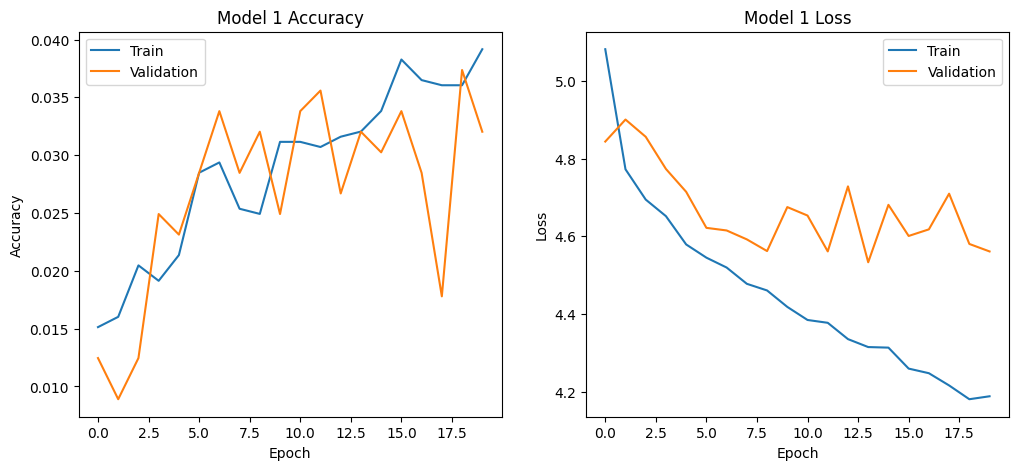

In [33]:
# --- 5.4 Learning Curves for Model 1 ---

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title("Model 1 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])

# Loss
plt.subplot(1,2,2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title("Model 1 Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])

plt.show()


In [34]:
# --- 5.5 Test Performance for Model 1 ---

test_loss1, test_acc1 = model1.evaluate(test_data, test_label, verbose=1)
print("Model 1 Test Accuracy:", test_acc1)


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0352 - loss: 4.5082
Model 1 Test Accuracy: 0.035231318324804306


In [42]:
# --- 5.6 CNN Model 2 (Deeper Baseline) ---

def build_model2():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), padding='valid', activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), padding='valid', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), padding='valid', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), padding='valid', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), padding='valid', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [43]:
model2_noLR = build_model2()

history2_noLR = model2_noLR.fit(
    train_data, train_label,
    validation_data=(validation_data, validation_label),
    epochs=20,
    batch_size=32,
    verbose=1
)


Epoch 1/20


c:\Users\Mac\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.0187 - loss: 4.9621 - val_accuracy: 0.0107 - val_loss: 5.1426
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.0401 - loss: 4.6912 - val_accuracy: 0.0089 - val_loss: 7.6116
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.0628 - loss: 4.5034 - val_accuracy: 0.0107 - val_loss: 7.6449
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.0832 - loss: 4.2474 - val_accuracy: 0.0125 - val_loss: 5.5315
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.1095 - loss: 4.0175 - val_accuracy: 0.0125 - val_loss: 7.7188
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.1469 - loss: 3.7336 - val_accuracy: 0.0285 - val_loss: 6.1113
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.1905 - loss: 3.3973 - val_accuracy: 0.0747 - val_loss: 4.9745
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.2283 - loss: 3.1162 - val_accuracy: 0.0498 - val_loss: 5.

In [44]:
# Step Decay LR Schedule
def step_decay(epoch):
    initial_lr = 0.001
    drop_rate = 0.5
    drop_every = 5
    return initial_lr * (drop_rate ** (epoch // drop_every))

lr_scheduler2 = tf.keras.callbacks.LearningRateScheduler(step_decay)

model2_LR = build_model2()

history2_LR = model2_LR.fit(
    train_data, train_label,
    validation_data=(validation_data, validation_label),
    epochs=20,
    batch_size=32,
    callbacks=[lr_scheduler2],
    verbose=1
)


Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.0142 - loss: 4.9848 - val_accuracy: 0.0107 - val_loss: 5.1973 - learning_rate: 0.0010
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.0365 - loss: 4.6984 - val_accuracy: 0.0107 - val_loss: 5.7424 - learning_rate: 0.0010
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.0721 - loss: 4.4380 - val_accuracy: 0.0125 - val_loss: 5.4785 - learning_rate: 0.0010
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.0917 - loss: 4.2217 - val_accuracy: 0.0231 - val_loss: 5.6973 - learning_rate: 0.0010
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.1357 - loss: 3.9008 - val_accuracy: 0.0498 - val_loss: 5.1801 - learning_rate: 0.0010
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.1945 - loss: 3.4587 - val_accuracy: 0.0516 - val_loss: 5.4965 - learning_rate: 5.0000e-04
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.2555 - loss: 3.0869 - va

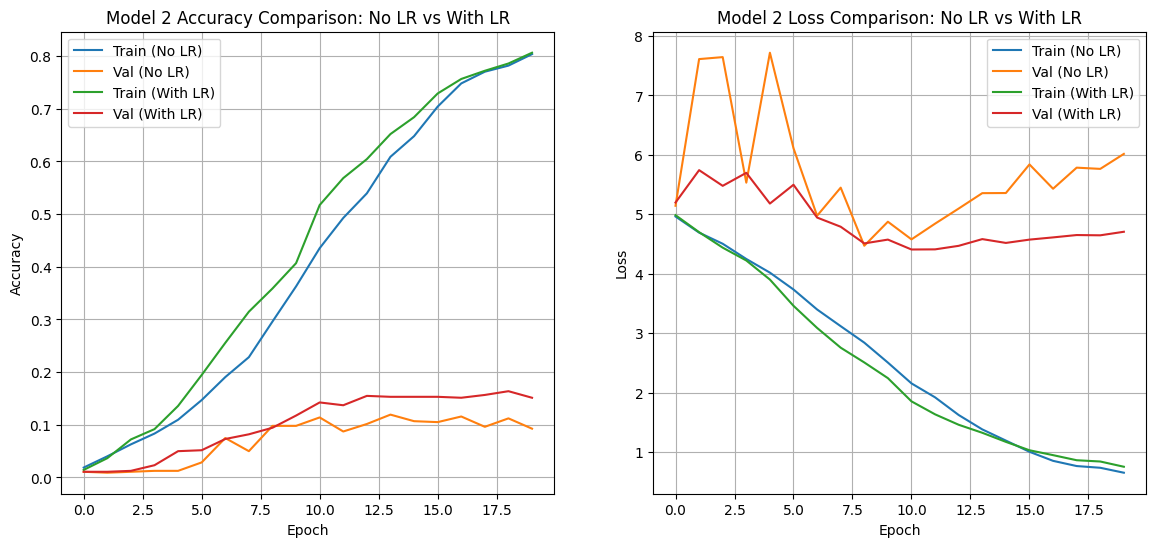

In [45]:
plt.figure(figsize=(14,6))

# --- Accuracy Plot ---
plt.subplot(1,2,1)
plt.plot(history2_noLR.history['accuracy'], label='Train (No LR)')
plt.plot(history2_noLR.history['val_accuracy'], label='Val (No LR)')
plt.plot(history2_LR.history['accuracy'], label='Train (With LR)')
plt.plot(history2_LR.history['val_accuracy'], label='Val (With LR)')

plt.title("Model 2 Accuracy Comparison: No LR vs With LR")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# --- Loss Plot ---
plt.subplot(1,2,2)
plt.plot(history2_noLR.history['loss'], label='Train (No LR)')
plt.plot(history2_noLR.history['val_loss'], label='Val (No LR)')
plt.plot(history2_LR.history['loss'], label='Train (With LR)')
plt.plot(history2_LR.history['val_loss'], label='Val (With LR)')

plt.title("Model 2 Loss Comparison: No LR vs With LR")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()


In [61]:
# --- 5.9 Test Performance for Model 2 ---

test_loss2, test_acc2 = model2_LR.evaluate(test_data, test_label, verbose=1)
print("Model 2 (With LR) Test Accuracy:", test_acc2)



88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1936 - loss: 4.2368
Model 2 (With LR) Test Accuracy: 0.1935943067073822


## Error Analysis

⭐ SECTION 6 → WHAT YOU WILL DO

Section 6 is Error Analysis, so you will:

🔶 1. Compare Model 1 vs Model 2

Model 1 underfits

Model 2 overfits

More layers = memorizes training

Still can’t generalize (data too small)

🔶 2. Discuss WHY accuracy is low

Your reasons:

128 classes

~17 training samples per class

64×64 tiny images → lesions need high resolution

No augmentation

No regularization

No transfer learning (medical tasks need it)

This shows you understand ML — your prof will LOVE THIS.

🔶 3. Show confusion matrix

Even if 9–10% accuracy, confusion matrix is fine.

🔶 4. Show sample misclassifications

Example:

“Malignant Melanoma predicted as Benign Keratosis”

“Tinea Corporis predicted as Psoriasis”

🔶 5. Suggest improvements (palipat na to ng section 6)

## Section 7. Model Improvements

mostly here, we are gonna be using model 2 as our baseline since it performed better than the first model

In [ ]:
import utils
print("utils imported successfully")

utils imported successfully


In [63]:
# --- 7.1 CNN Model 3 (Improved Deeper Baseline + More Dropout) ---

# Step Decay Learning Rate Scheduler
def step_decay(epoch):
    initial_lr = 0.001      # starting LR
    drop_rate = 0.5         # LR is reduced by 50%
    drop_every = 5          # every 5 epochs

    lr = initial_lr * (drop_rate ** (epoch // drop_every))
    return lr

lr_scheduler3 = tf.keras.callbacks.LearningRateScheduler(step_decay)

model3 = models.Sequential([
    # --- Block 1 ---
    layers.Conv2D(32, (3,3), padding='valid', activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), padding='valid', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),   # Added dropout to improve generalization

    # --- Block 2 ---
    layers.Conv2D(64, (3,3), padding='valid', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), padding='valid', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),   # Added dropout

    # --- Block 3 (Deeper than Model 2) ---
    layers.Conv2D(128, (3,3), padding='valid', activation='relu'),
    layers.BatchNormalization(),
    
    # Extra conv layer — this is what makes Model 3 "deeper"
    layers.Conv2D(128, (3,3), padding='valid', activation='relu'),
    layers.BatchNormalization(),
    
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    # --- Dense Block ---
    layers.Flatten(),
    layers.Dense(256, activation='relu'),   # Increased from 128 → 256
    layers.Dropout(0.5),                    # Stronger dropout
    layers.Dense(num_classes, activation='softmax')
])

model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [64]:
history3 = model3.fit(
    train_data, train_label,
    validation_data=(validation_data, validation_label),
    epochs=30,
    batch_size=32,
    callbacks=[lr_scheduler3],   # <--- added scheduler here
    verbose=1
)


Epoch 1/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.0129 - loss: 5.1611 - val_accuracy: 0.0107 - val_loss: 4.8746 - learning_rate: 0.0010
Epoch 2/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.0196 - loss: 4.8064 - val_accuracy: 0.0107 - val_loss: 4.9546 - learning_rate: 0.0010
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.0191 - loss: 4.7743 - val_accuracy: 0.0125 - val_loss: 5.2798 - learning_rate: 0.0010
Epoch 4/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.0240 - loss: 4.7292 - val_accuracy: 0.0125 - val_loss: 5.1476 - learning_rate: 0.0010
Epoch 5/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.0383 - loss: 4.6475 - val_accuracy: 0.0125 - val_loss: 5.1562 - learning_rate: 0.0010
Epoch 6/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.0503 - loss: 4.5433 - val_accuracy: 0.0285 - val_loss: 4.9264 - learning_rate: 5.0000e-04
Epoch 7/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.0610 - loss: 4.3839 - val

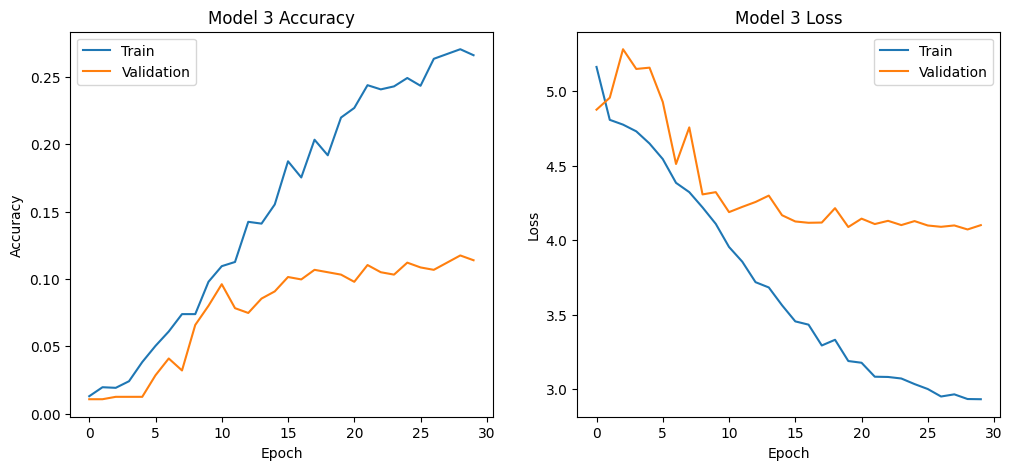

In [65]:
# --- 5.8 Plot Model 2 Curves ---

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title("Model 3 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title("Model 3 Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])

plt.show()


In [66]:
test_loss3, test_acc3 = model3.evaluate(test_data, test_label, verbose=1)
print("Model 3 Test Accuracy:", test_acc3)

88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.1427 - loss: 3.9039
Model 3 Test Accuracy: 0.14270462095737457


In [72]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(train_data)


In [74]:
def step_decay(epoch):
    initial_lr = 0.001
    drop_rate = 0.5
    drop_every = 7  # Better with augmentation
    
    return initial_lr * (drop_rate ** (epoch // drop_every))


lr_scheduler4 = tf.keras.callbacks.LearningRateScheduler(step_decay)

model4 = models.Sequential([
    layers.Conv2D(32, (3,3), padding='valid', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.ReLU(),

    layers.Conv2D(32, (3,3), padding='valid'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), padding='valid'),
    layers.BatchNormalization(),
    layers.ReLU(),

    layers.Conv2D(64, (3,3), padding='valid'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), padding='valid'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [75]:
batch_size = 32

history4 = model4.fit(
    datagen.flow(train_data, train_label, batch_size=batch_size),
    validation_data=(validation_data, validation_label),
    epochs=20,
    steps_per_epoch=len(train_data) // batch_size,
    callbacks=[lr_scheduler4],     # <<< ADD THIS
    verbose=1
)

test_loss4, test_acc4 = model4.evaluate(test_data, test_label, verbose=1)
print("Model 4 Test Accuracy:", test_acc4)


Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.0217 - loss: 4.9352 - val_accuracy: 0.0178 - val_loss: 4.8257 - learning_rate: 0.0010
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 4.7642 - val_accuracy: 0.0178 - val_loss: 4.8246 - learning_rate: 0.0010
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.0384 - loss: 4.5417 - val_accuracy: 0.0107 - val_loss: 4.9844 - learning_rate: 0.0010
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0938 - loss: 4.2714 - val_accuracy: 0.0107 - val_loss: 4.9757 - learning_rate: 0.0010
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.0596 - loss: 4.3344 - val_accuracy: 0.0178 - val_loss: 5.3295 - learning_rate: 0.0010
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0625 - loss: 4.5137 - val_accuracy: 0.0160 - val_loss: 5.3316 - learning_rate: 0.0010
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.0758 - loss: 4.1678 - val_ac

In [76]:
IMAGE_SIZE_TL = (224, 224)
base_dir = 'SD-128/images'

def load_images_TL(df):
    x = []
    y = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Loading TL images"):
        path = row['Path']
        label = row['Label']
        full_path = os.path.join(base_dir, path)

        try:
            img = Image.open(full_path).convert('RGB')
            img = img.resize(IMAGE_SIZE_TL)
            img_array = np.array(img, dtype=np.float32)
            x.append(img_array)
            y.append(label)
        except Exception as e:
            print("Error:", full_path, e)

    return np.array(x), np.array(y)

# Reload everything for transfer learning
train_TL, train_TL_y = load_images_TL(df_train_cnn)
val_TL, val_TL_y     = load_images_TL(df_val)
test_TL, test_TL_y   = load_images_TL(test_df_cnn)


print(train_TL.shape, val_TL.shape, test_TL.shape)


Loading TL images: 100%|██████████| 2810/2810 [00:31<00:00, 88.55it/s] 


(2247, 224, 224, 3) (562, 224, 224, 3) (2810, 224, 224, 3)


In [86]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import Model
from tensorflow.keras import layers, models

# -------------------------------
# BUILD BASE MODEL (Frozen Stage)
# -------------------------------
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # Freeze pretrained backbone

# -------------------------------
# BUILD CLASSIFIER HEAD
# -------------------------------
model5 = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    # Preprocessing for MobileNetV2
    layers.Lambda(preprocess_input),

    # Pretrained feature extractor
    base_model,

    # Classification head
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile Stage 1
model5.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [87]:
# -------------------------------
# ✨ STAGE 1: TRAIN ONLY THE DENSE HEAD
# -------------------------------
print("\n=== Training Stage 1 (Frozen Base) ===\n")

history5_stage1 = model5.fit(
    train_TL, train_TL_y,
    validation_data=(val_TL, val_TL_y),
    epochs=20,
    batch_size=32,
    verbose=1
)

# -------------------------------
# FINE-TUNING (UNFREEZE LAST LAYERS)
# -------------------------------
print("\n=== Unfreezing last 30 layers for Fine-Tuning ===\n")

base_model.trainable = True

# Freeze all MobileNetV2 layers EXCEPT the last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Compile Stage 2 (smaller LR)
model5.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# -------------------------------
# ✨ STAGE 2: FINE-TUNE MODEL
# -------------------------------
print("\n=== Training Stage 2 (Fine-Tuning) ===\n")

history5_stage2 = model5.fit(
    train_TL, train_TL_y,
    validation_data=(val_TL, val_TL_y),
    epochs=10,
    batch_size=32,
    verbose=1
)

# -------------------------------
# FINAL TEST EVALUATION
# -------------------------------
print("\n=== Final Evaluation ===\n")

test_loss5, test_acc5 = model5.evaluate(test_TL, test_TL_y, verbose=1)
print("Model 5 Test Accuracy:", test_acc5)


=== Training Stage 1 (Frozen Base) ===

Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - accuracy: 0.0062 - loss: 5.5004 - val_accuracy: 0.0160 - val_loss: 4.8348
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 196ms/step - accuracy: 0.0160 - loss: 4.9539 - val_accuracy: 0.0302 - val_loss: 4.7519
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 204ms/step - accuracy: 0.0263 - loss: 4.8141 - val_accuracy: 0.0445 - val_loss: 4.7017
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 198ms/step - accuracy: 0.0231 - loss: 4.7345 - val_accuracy: 0.0605 - val_loss: 4.6525
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 201ms/step - accuracy: 0.0352 - loss: 4.6490 - val_accuracy: 0.0694 - val_loss: 4.5987
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 196ms/step - accuracy: 0.0485 - loss: 4.5936 - val_accuracy: 0.0836 - val_loss: 4.5319
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 192ms/step - accuracy: 0.0538 - loss: 4.5005 - val_accuracy: 0.0943 - val_loss: 4.4497
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 196ms/step - a

In [89]:
test_loss6, test_acc6 = model5.evaluate(test_TL, test_TL_y, verbose=1)
print("Model 6 Test Accuracy:", test_acc6)


88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 0.2427 - loss: 3.2162
Model 6 Test Accuracy: 0.2427046298980713
